## PointNet-based autoencoder for 3D point clouds

Let us now consider a deep learning approach based on the PointNet architecture.

 It is based on a convolutional neural network (CNN) architecture. The PointNet architecture is described in the paper [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593). 


### Dataset preparation

We want to train a PointNet-based autoencoder on selected classes separately, in order to maximize the decoding quality.

In particular, we noticed that there are some classes (road, sidewalk, ego vehicle, building, vegetation, car) whose number of points is orders of magnitude larger than the others. therefore, we will train a separate autoencoder for each of these classes and build an ensemble of autoencoders, each of which trained on these classes.


To tihs end, we do the following:
1) Pick 500 point clouds from left, right and top LIDARS;
2) Combine the points from the 3 LIDARS into a single point cloud;
3) For each selected class among the 6 classes mentioned above, we extract the points belonging to that class and save them in a separate file;
4) Train an autoencoder on each of the 6 classes separately;
5) Build an ensemble of autoencoders, each of which trained on a different class.


In [15]:
import argparse
import numpy as np
import open3d
import os
import torch
import plyfile as ply
import torch.nn as nn
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import open3d as o3d
from tqdm import tqdm
from glob import glob

In [1]:

def combine (
    main_dir, 
    Nfiles=100,
    outdir='dataset_final',
    ):
    import glob 
    # find all scan codes
    left_lidar_codes = glob.glob(os.path.join(main_dir, 'LIDAR_FRONT_LEFT', '*.ply'))
    left_lidar_codes = [f.split('/')[-1].split('.')[0] for f in left_lidar_codes]
    left_lidar_codes.sort()
    print (f"Number of left lidar codes: {len(left_lidar_codes)}")

    right_lidar_codes = glob.glob(os.path.join(main_dir, 'LIDAR_FRONT_RIGHT', '*.ply'))
    right_lidar_codes = [f.split('/')[-1].split('.')[0] for f in right_lidar_codes]
    right_lidar_codes.sort()
    print (f"Number of left lidar codes: {len(left_lidar_codes)}")

    top_lidar_codes = glob.glob(os.path.join(main_dir, 'LIDAR_TOP', '*.ply'))
    top_lidar_codes = [f.split('/')[-1].split('.')[0] for f in top_lidar_codes]
    top_lidar_codes.sort()
    print (f"Number of left lidar codes: {len(left_lidar_codes)}")

    # find intersection of scan code
    print ("Finding intersection of scan codes")
    scan_codes = set(left_lidar_codes).intersection(set(right_lidar_codes)).intersection(set(top_lidar_codes))
    scan_codes = list(scan_codes)
    scan_codes.sort()
    scan_codes = scan_codes[:Nfiles]
    print (f"Number of scan codes: {len(scan_codes)}")


    # combine lidar data
    all_lidars = ['LIDAR_FRONT_LEFT', 'LIDAR_FRONT_RIGHT', 'LIDAR_TOP']
    outdir = os.path.join(main_dir, outdir)
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # save combined point clouds and labels
    for code in tqdm(scan_codes):
        pcd_combined = o3d.geometry.PointCloud() 
        labels = []
        for lidar in all_lidars:
            file = os.path.join(main_dir, lidar,  code + '.ply')
            # load labels, i.e the  PlyProperty('ObjTag', 'uchar')), fourth property of the ply file
            plydata = ply.PlyData.read(file)
            labels += list(np.array(plydata.elements[0].data['ObjTag']))
            
            # load point clouds
            pc = o3d.io.read_point_cloud(file, format='ply')
            pcd_combined += pc

        

        # get labels
        labels = np.array(labels)
        #save labels
        # np.save(os.path.join(outdir, code + '_labels.npy'), labels)
        o3d.io.write_point_cloud(os.path.join(outdir, code + '.ply'), pcd_combined)

        # read again the file with plyfile and add the labels as a property
        plydata = ply.PlyData.read(os.path.join(outdir, code + '.ply'))

        # add the labels as a property
        x, y, z = plydata.elements[0].data['x'], plydata.elements[0].data['y'], plydata.elements[0].data['z']
        element = ply.PlyElement.describe(np.array(list(zip(x, y, z, labels)), dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('ObjTag', 'u1')]), 'vertex')
        plydata.elements = [element]
        plydata.write(os.path.join(outdir, code + '.ply'))
        

In [18]:
root = '../dataset-downloader-kit/CV/dataset/Town01_Opt_ClearSunset'
combine(root, Nfiles=500, outdir='dataset_autoencoder')


Number of left lidar codes: 1634
Number of left lidar codes: 1634
Number of left lidar codes: 1634
Finding intersection of scan codes
Number of scan codes: 500


100%|██████████| 500/500 [09:23<00:00,  1.13s/it]


In [2]:
def class_autoencoder(
    root_dir,
    Nfiles=100,
    classes = [1,100, 7, 8, 9, 10], 
    outdir='dataset_autoencoder_labels',
    ):
    import glob
    # all files in the directory
    all_files = glob.glob(os.path.join(root_dir, '*.ply'))
    all_files.sort()
    print (f"Number of files: {len(all_files)} in {root_dir}")
    # read all the files and get the point clouds corresponding to the classes
    for file in tqdm(all_files):
        plydata = ply.PlyData.read(file)
        labels = np.array(plydata.elements[0].data['ObjTag']) # get the labels

        for lab in classes:

            # save the point clouds
            lab_points = plydata.elements[0].data[labels == lab]

            # save the labels
            lab_points = ply.PlyElement.describe(lab_points, 'vertex')
            lab_points = ply.PlyData([lab_points])

            save_dir = os.path.join (outdir, "label_" + str(lab))
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
                
            lab_points.write( os.path.join(save_dir, file.split('/')[-1]) )


In [ ]:

root = '../dataset-downloader-kit/CV/dataset/Town01_Opt_ClearSunset/dataset_autoencoder'
class_autoencoder(root, Nfiles=500, outdir='dataset_autoencoder_labels')

In [3]:
# reorganize in subset with val and train
import shutil
def split_train_test(train_ratio=0.8):
    for l in [1,100, 7, 8, 9, 10]:
        directory = os.path.join('dataset_autoencoder_labels', 'label_' + str(l))
        # create train and val directories
        train_dir = os.path.join(directory, 'train_data')
        val_dir = os.path.join(directory, 'val_data')

        all_files = glob(os.path.join(directory, '*.ply'))
        all_files.sort()
        Nfiles = len(all_files)
        Ntrain = int(train_ratio * Nfiles)
        Nval = Nfiles - Ntrain

        # create train and val directories
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(val_dir):
            os.makedirs(val_dir)

        # move files
        for i, file in enumerate(all_files):
            if i < Ntrain:
                shutil.move(file, train_dir)
            else:
                shutil.move(file, val_dir)


In [4]:
split_train_test()

## Training and testing

The training is performed by means of an external script, that we dont show here for sake of brevity. 

The bash script to run all the trainings follows:

```bash
for class_index in 1 100 7 8 9 10
do
    root_dir="dataset_autoencoder_labels/label_"$class_index
    save_dir="checkpoints/checkpoints_label_"$class_index
    python train.py --root $root_dir --batchsize 32 --epoches 40 --saved_path $save_dir
done
```

We report the code below, even though the run has been performed with python scripts instead of jupyter notebooks.


### Autoencoder code
The following cell contains the code for the autoencoder. The code is based on the PointNet architecture,  and consists of a convolutional for reconstruction, where Convolutions are combined with maxpooling and a set of fully connected layers.

In particular:


```python
import open3d as o3d
import os
import torch
import torch.nn as nn
import sys


class Autoencoder(nn.Module):
    def linear_block_en(self, flatten_dim, out_dims=[32, 16, 8]):
        layers = []
        in_dim = flatten_dim
        for out_dim in out_dims:
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
            in_dim = out_dim
        return nn.Sequential(*layers)


    def linear_block_de(self, in_dims=[8, 16, 32], flatten_dim=64, unflatten_dim=(64,64)):
        layers = []
        in_dim = in_dims[0]
        for out_dim in in_dims[1:]:
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
            in_dim = out_dim

        layers.append(nn.Linear(in_dim, flatten_dim))
        layers.append(nn.Unflatten(1, unflatten_dim))

        return nn.Sequential(*layers)


    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 16, kernel_size=3)
        self.maxpool1 = nn.MaxPool1d(kernel_size=5, return_indices=True)
    
        self.encoder1 = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(16, 32,kernel_size=3, padding='same'),
        )
        self.maxpool2 = nn.MaxPool1d(kernel_size=5, return_indices=True)

        self.encoder2 = nn.Sequential(
            nn.Tanh(),
            nn.Conv1d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
        )
        # flatten 
        self.flatten = nn.Flatten()

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.maxunpool1 = nn.MaxUnpool1d(kernel_size=5)

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose1d(32,16,kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.unmaxunpool2 = nn.MaxUnpool1d(kernel_size=5)
        self.unconv1 = nn.ConvTranspose1d(16,3,kernel_size=3)

        self.float()

    def forward(self, x):

        x = self.conv1(x)
        outputsize1 = x.shape
        x,indices1 = self.maxpool1(x)
        x = self.encoder1(x)

        outsize2 = x.shape
        x,indices2 = self.maxpool2(x)
        x = self.encoder2(x)

        unflatten_dim = x.shape[1:]

        # flatten
        x = self.flatten(x)
        flatten_dim = x.shape[1]
        coding = self.linear_block_en(flatten_dim)(x)
        # unflatten
        x = self.linear_block_de(flatten_dim=flatten_dim, unflatten_dim=unflatten_dim) (coding)
        x = self.decoder2(x)
        x = self.unmaxunpool2(x, output_size = outsize2, indices=indices2)
        x = self.decoder1(x)
        x = self.maxunpool1(x, output_size = outputsize1, indices=indices1)
        x = self.unconv1(x)

        output = nn.Tanh()(x)

        return coding, output
```

### Dataset and transforms

```python

import numpy as np
import os
import torch
from torch.utils.data import Dataset


def readpcd(path, rtype='pcd'):
    assert rtype in ['pcd', 'npy']
    pcd = o3d.io.read_point_cloud(path)
    if rtype == 'pcd':
        return pcd
    npy = np.asarray(pcd.points).astype(np.float32)
    return npy

def pc_normalize(pc):
    mean = np.mean(pc, axis=0)
    pc -= mean
    m = np.max(np.sqrt(np.sum(np.power(pc, 2), axis=1)))
    pc /= m
    return pc

def random_select_points(pc, m):
    if m < 0:
        idx = np.arange(pc.shape[0])
        np.random.shuffle(idx)
        return pc[idx, :]
    n = pc.shape[0]
    replace = False if n >= m else True
    idx = np.random.choice(n, size=(m, ), replace=replace)
    return pc[idx, :]

class CustomData(Dataset):
    def __init__(self, root, npts, train=True,  nfiles=None):
        super(CustomData, self).__init__()
        dirname = 'train_data' if train else 'val_data'
        path = os.path.join(root, dirname)
        self.train = train

        self.files = [os.path.join(path, item) for item in sorted(os.listdir(path))]
        if nfiles is not None:
            self.files = self.files[:nfiles]
            
        # only if point cloud is not empty
        self.files = [item for item in self.files if readpcd(item).has_points()]
        self.npts = npts

    def __getitem__(self, item):
        file = self.files[item]
        ref_cloud = readpcd(file, rtype='npy')
        ref_cloud = random_select_points(ref_cloud, m=self.npts)
        ref_cloud = pc_normalize(ref_cloud)
       
        return ref_cloud
        
    def __len__(self):
        return len(self.files)

```

### Training loop

The following cell contains the training loop, please do not run this cell, which is meant to be here 

```python

import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

def time_calc(func):
    def wrapper(*args, **kargs):
        start_time = time.time()
        f = func(*args, **kargs)
        print('{}: {:.2f} s'.format(func.__name__, time.time() - start_time))
        return f
    return wrapper
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def setup_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)


# soppress user warnings
import warnings
warnings.filterwarnings("ignore")
def config_params():
    parser = argparse.ArgumentParser(description='Configuration Parameters')
    ## dataset
    parser.add_argument('--root',help='the data path', default='dataset_final')
    parser.add_argument('--load', type=bool, default=True,
                        help='whether to load the trained model')
    parser.add_argument('--train_npts', type=int,  default=4000,
                        help='the points number of each pc for training')
    ## models training
    parser.add_argument('--seed', type=int, default=1234)
    parser.add_argument('--gn', action='store_true',
                        help='whether to use group normalization')
    parser.add_argument('--epoches', type=int, default=20)
    parser.add_argument('--batchsize', type=int, default=4)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--in_dim', type=int, default=3,
                        help='3 for (x, y, z) or 6 for (x, y, z, nx, ny, nz)')
    parser.add_argument('--niters', type=int, default=8,
                        help='iteration nums in one model forward')
    parser.add_argument('--lr', type=float, default=0.0001,
                        help='initial learning rate')
    parser.add_argument('--milestones', type=list, default=[50, 250],
                        help='lr decays when epoch in milstones')
    parser.add_argument('--gamma', type=float, default=0.1,
                        help='lr decays to gamma * lr every decay epoch')
    # logs
    parser.add_argument('--saved_path', default='work_dirs/models',
                        help='the path to save training logs and checkpoints')
    parser.add_argument('--saved_frequency', type=int, default=1,
                        help='the frequency to save the logs and checkpoints')
    args = parser.parse_args()
    return args


def compute_loss(ref_cloud, pred_ref_clouds, loss_fn):
    losses = []
    discount_factor = 0.5
    for i in range(8):
        loss = loss_fn(ref_cloud[..., :3].contiguous(),
                       pred_ref_clouds[i][..., :3].contiguous())
        losses.append(discount_factor**(8 - i)*loss)
    return torch.sum(torch.stack(losses))

import sys

@time_calc
def train_one_epoch(train_loader, model, loss_fn, optimizer):
    losses = []
    compression_ratios = []
    for ref_cloud in tqdm(train_loader):
        ref_cloud = ref_cloud.to(device)

        optimizer.zero_grad()
        encoded, decoded = model(ref_cloud.permute(0,2,1).contiguous())

        loss = loss_fn(ref_cloud.permute(0,2,1).contiguous(), decoded)

        #product shapes normalized over batch_size
        encoding_size = encoded.shape[1]
        ref_cloud_size = ref_cloud.shape[1] * ref_cloud.shape[2]
        
        compression_ratio = encoding_size / ref_cloud_size
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        compression_ratios.append(compression_ratio)
    
    results = {
        'loss': np.mean(losses),
        'compression_ratio': np.mean(compression_ratios)
    }
    return results


@time_calc
def test_one_epoch(test_loader, model, loss_fn):
    model.eval()
    losses = []
    compression_ratios = []

    with torch.no_grad():
        for ref_cloud in tqdm(test_loader):
            ref_cloud = ref_cloud.to(device)
            encoded, decoded = model(ref_cloud.permute(0,2,1).contiguous())

            loss = loss_fn(ref_cloud.permute(0,2,1).contiguous(), decoded)

            #product shapes normalized over batch_size
            encoding_size = encoded.shape[1]
            ref_cloud_size = ref_cloud.shape[1] * ref_cloud.shape[2]
            
            compression_ratio = encoding_size / ref_cloud_size

            losses.append(loss.item())
            compression_ratios.append(compression_ratio) 
    model.train()
    results = {
        'loss': np.mean(losses),
        'compression_ratio': np.mean(compression_ratios)
    }
    return results


def main():
    args = config_params()
    print(args)

    print ('Setting up data...')
    setup_seed(args.seed)
    if not os.path.exists(args.saved_path):
        os.makedirs(args.saved_path)
    summary_path = os.path.join(args.saved_path, 'summary')
    if not os.path.exists(summary_path):
        os.makedirs(summary_path)
    checkpoints_path = os.path.join(args.saved_path, 'checkpoints')
    if not os.path.exists(checkpoints_path):
        os.makedirs(checkpoints_path)
    
    train_set = CustomData(args.root, args.train_npts)
    test_set = CustomData(args.root, args.train_npts, False)
    train_loader = DataLoader(train_set, batch_size=args.batchsize,
                              shuffle=True, num_workers=args.num_workers)
    test_loader = DataLoader(test_set, batch_size=args.batchsize, shuffle=False,
                             num_workers=args.num_workers)

    # test dataset
    print ('test dataset', len(test_set))
    print ('train dataset', len(train_set))

    # load model if exists from checkpoints
    import glob
    model_paths = glob.glob(os.path.join(checkpoints_path, 'model_*.pth'))
    model_paths.sort()
    epochs = [int(path.split('_')[-1].split('.')[0]) for path in model_paths]
    start_epoch = max(epochs) if len(epochs) > 0 else 0
    from autoencoder import Autoencoder
    # model = Autoencoder(in_dim=args.in_dim,  gn = args.gn)
    model = Autoencoder()
    if len(model_paths) > 0 and args.load:
        model_path = os.path.join(checkpoints_path, 'model_{}.pth'.format(start_epoch))
        print('load model from {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))

        print('start from epoch {}'.format(start_epoch))
        max_epoch = args.epoches
        print ('max epoch', max_epoch)
    else: 
        max_epoch = args.epoches

    model = model.to(device)

    loss_fn = torch.nn.MSELoss()
    loss_fn = loss_fn.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=args.milestones,
                                                     gamma=args.gamma,
                                                     last_epoch=-1)

    


    test_min_loss  = float('inf')
    import pandas as pd
    train_results_all = pd.DataFrame(columns=['loss', 'compratio'])
    test_results_all = pd.DataFrame(columns=['loss', 'compratio'])

    # save loss and compression ratio
    if not os.path.exists(os.path.join(checkpoints_path, 'results')):
        os.makedirs(os.path.join(checkpoints_path, 'results'))

    # load results if exists
    if os.path.exists(os.path.join(checkpoints_path, 'results', 'train_results_all.csv')):
        train_results_all = pd.read_csv(os.path.join(checkpoints_path, 'results', 'train_results_all.csv'))
        test_results_all = pd.read_csv(os.path.join(checkpoints_path, 'results', 'test_results_all.csv'))
        print('load results from {}'.format(os.path.join(checkpoints_path, 'results')))
        print('start from epoch {}'.format(start_epoch))
        max_epoch = args.epoches
        print ('max epoch', max_epoch)

    for epoch in range(start_epoch, max_epoch):
        print('=' * 20, epoch + 1, '=' * 20)
        train_results = train_one_epoch(train_loader, model, loss_fn, optimizer)
        test_results = test_one_epoch(test_loader, model, loss_fn)
        print('train loss: {:.4f}, train compratio: {:.4f}'.format(train_results['loss'], train_results['compression_ratio']))

        # save loss and compression ratio
        train_results_all = pd.concat([train_results_all, pd.DataFrame(train_results, index=[0])], ignore_index=True)
        test_results_all = pd.concat([test_results_all, pd.DataFrame(test_results, index=[0])], ignore_index=True)
        
        test_loss = test_results['loss']

        test_min_loss = min(test_min_loss, test_loss)
        if test_loss < test_min_loss:
            saved_path = os.path.join(checkpoints_path, "test_min_loss.pth")
            torch.save(model.state_dict(), saved_path)
            test_min_loss = test_loss
        
        saved_path = os.path.join(checkpoints_path, "model_{}.pth".format(epoch))
        torch.save(model.state_dict(), saved_path)


        scheduler.step()

        train_results_all.to_csv(os.path.join(checkpoints_path, 'results', 'train_results_all.csv'), index=False)
        test_results_all.to_csv(os.path.join(checkpoints_path, 'results', 'test_results_all.csv'), index=False)

```

### Reorganize the results

We saved the results in proper csv file, the followin cells are dedicated to load the results and reorganize them in a proper way.



In [1]:
# results are saved in the folder checkpoints/label_{}/checkpoints/reusults 
import pandas as pd
import numpy as np
path_results = 'checkpoints/label_{}/checkpoints/results/'

test_format = 'test_results_all.csv'
train_format = 'train_results_all.csv'

all_results_test = pd.DataFrame()
all_results_train = pd.DataFrame()

for l in [1,7,8,9,10,100]:
    temp_test = pd.read_csv(path_results.format(l)+test_format)
    temp_train = pd.read_csv(path_results.format(l)+train_format)

    # add label column
    temp_test['label'] = l
    temp_train['label'] = l

    # add epoch column
    temp_test['epoch'] = np.arange(1, len(temp_test)+1)
    temp_train['epoch'] = np.arange(1, len(temp_train)+1)

    #concatenate
    all_results_test = pd.concat([all_results_test, temp_test], axis=0)
    all_results_train = pd.concat([all_results_train, temp_test], axis=0)

In [2]:
all_results_train

,loss,compression_ratio,label,epoch
0,0.077767,0.000667,1,1
1,0.073402,0.000667,1,2
2,0.068899,0.000667,1,3
3,0.064552,0.000667,1,4
4,0.060276,0.000667,1,5
...,...,...,...,...
37,0.009189,0.000667,100,38
38,0.008999,0.000667,100,39
39,0.008968,0.000667,100,40
40,0.008907,0.000667,100,41


In [3]:
label_name_map = {
    0: 'Unlabeled', 
    1: 'Building',
    2: 'Fence',
    3: 'Other',
    5: 'Pole',
    6: 'Road Line',
    7: 'Road',
    8: 'Sidewalk',
    9: 'Vegetation',
    10: 'ego vehicle',
    11: 'wall',
    12: 'traffic sign',
    13: 'sky',
    14: 'ground',
    15: 'bridge',
    16: 'rail track',
    17: 'guard rail',
    18: 'traffic light',
    19: 'static',
    20: 'dynamic',
    21: 'water',
    22: 'terrain',
    40: 'person',
    41: 'rider',
    100: 'car',
    101: 'truck',
    102: 'bus',
    103: 'tram/train',
    104: 'motorcycle',
    105: 'unknown',
}


### Performances 
Once the training is completed, we can test the autoencoders on the test set. 

The plot below shows the MSE evolution through epoches and the sum of all the MSEs. Indeed the sum of all the MSEs is a good indicator of the overall performance of the autoencoder on the total PC.

In [4]:
total_test_mse = all_results_test.groupby('epoch')['loss'].sum()
total_test_mse = total_test_mse.reset_index()

total_train_mse = all_results_train.groupby('epoch')['loss'].sum()
total_train_mse = total_train_mse.reset_index()

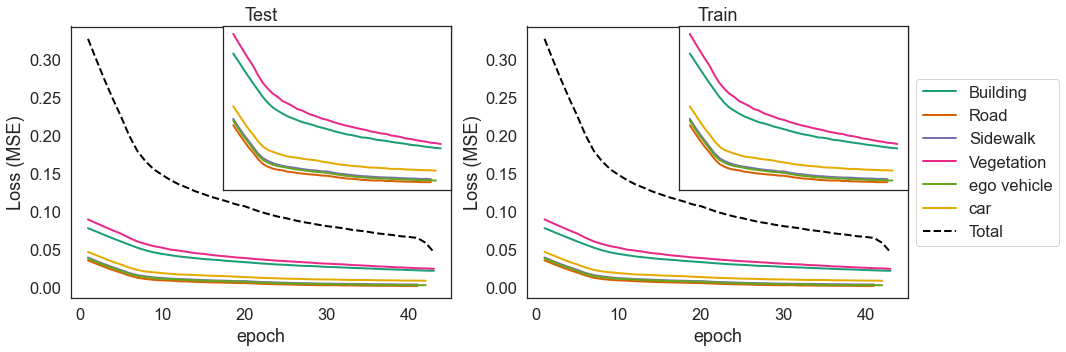

In [5]:
# plot compression ratio and mse for each label
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", font_scale=1.5, palette='Dark2')
fig, ax = plt.subplots(1,2, figsize=(15,5))
lw=2

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# line plots for loss (MSE)
for l in [1,7,8,9,10,100]:
    sns.lineplot(data=all_results_test[all_results_test['label']==l], 
                x='epoch', y='loss', ax=ax[0], label=label_name_map[l],
                linewidth=lw)

    sns.lineplot(data=all_results_train[all_results_train['label']==l], 
                x='epoch', y='loss', ax=ax[1], label=label_name_map[l],
                linewidth=lw)

# total loss
sns.lineplot(data=total_test_mse,
            x='epoch', y='loss', ax=ax[0], label='Total',
            linewidth=lw, linestyle='--', color='black')

sns.lineplot(data=total_train_mse,
            x='epoch', y='loss', ax=ax[1], label='Total',
            linewidth=lw, linestyle='--', color='black')
    
inset_ax_0 = ax[0].inset_axes([0.4, 0.4, 0.6, 0.6])
inset_ax_1 = ax[1].inset_axes([0.4, 0.4, 0.6, 0.6])


# line plots for loss (MSE)
for l in [1,7,8,9,10,100]:
    sns.lineplot(data=all_results_test[all_results_test['label']==l], 
                x='epoch', y='loss', ax=inset_ax_0, label=label_name_map[l],
                linewidth=lw)
    sns.lineplot(data=all_results_train[all_results_train['label']==l], 
            x='epoch', y='loss', ax=inset_ax_1, label=label_name_map[l],
            linewidth=lw)

inset_ax_0.set_xlabel(''), inset_ax_0.set_ylabel('')
inset_ax_0.set_xticklabels([]), inset_ax_0.set_yticklabels([])
inset_ax_1.set_xlabel(''), inset_ax_1.set_ylabel('')
inset_ax_1.set_xticklabels([]), inset_ax_1.set_yticklabels([])
inset_ax_1.legend_.remove()
inset_ax_0.legend_.remove()


#remove legend from fisrt
ax[0].legend_.remove()
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax[0].set_title('Test'), ax[1].set_title('Train')
ax[0].set_ylabel('Loss (MSE)'), ax[1].set_ylabel('Loss (MSE)')

# save pdf
plt.savefig('loss.pdf', bbox_inches='tight')

In [7]:
# plot best mse vs compression ratio
best_mse = all_results_test.groupby('label')['loss'].min() # for each label
comp_ratio = all_results_test.groupby('label')['compression_ratio'].mean() # for each label

best_performances = pd.DataFrame(columns=['MSE', 'compression_ratio'])
best_performances['compression_ratio'] = comp_ratio
best_performances['MSE'] = best_mse
labels = best_performances.index

# add total loss
total_loss = sum(best_performances['MSE'])
comp_ratio_total = np.mean(best_performances['compression_ratio'])
best_performances = best_performances.append({'MSE': total_loss, 'compression_ratio': comp_ratio_total}, ignore_index=True)

/var/folders/gq/gwfhyzf925b2_vdp2wp5svf00000gr/T/ipykernel_80970/326558663.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_performances = best_performances.append({'MSE': total_loss, 'compression_ratio': comp_ratio_total}, ignore_index=True)


In [8]:
labels = labels.append(pd.Index(['Total']))
best_performances.index = labels

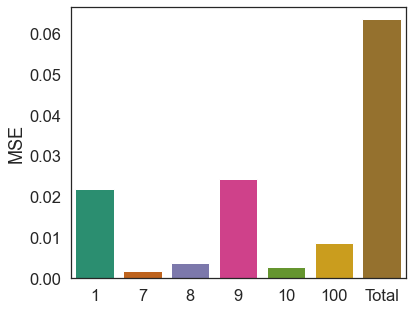

In [9]:
# plot compression ratio and mse for each label
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax  = plt.subplots(1,1, figsize=(6,5))
sns.barplot(x=best_performances.index, y=best_performances['MSE'])
# save pdf 
plt.savefig('total_MSE_per_class.pdf', bbox_inches='tight')

In [13]:
best_performances.index = labels
best_performances.index.name = 'label'
best_performances

,MSE,compression_ratio
label,,
1,0.021848,0.000667
7,0.001895,0.000667
8,0.003655,0.000667
9,0.024405,0.000667
10,0.002872,0.000667
100,0.008697,0.000667
Total,0.063372,0.000667


## 3D point cloud reconstruction

We decided to compress the points corresponding to labels with high frequency w.r.t the rest of the labels. In particular, we decided to compress the points corresponding to the following labels: road, sidewalk, ego vehicle, building, vegetation, car.

Therefore, in order to reconstruct the 3D point cloud, we do the following:

1. For each of the 6 classes, compress it and reconstruct it using the corresponding autoencoder;
2. Combine the 6 reconstructed point clouds into a single point cloud;
3. Add all the points that belong to the other labels (pedestrian, cyclist, traffic sign, traffic light, etc.) to the reconstructed point cloud.

In [22]:
entirePCPath = '../Town01_Opt_ClearSunset_103317935097620212.ply'
import open3d as o3d
# original PC
original_pc = o3d.io.read_point_cloud(entirePCPath)

## Create the ensample of autoencoders

Each autoencoder will take care of a specific class. 


Let us now visualize the results of the autoencoders on a sample point cloud.

We apply the proper autoencoder to the point cloud and we visualize the results.

In [51]:
models_paths = 'checkpoints/label_{}/checkpoints/model_39.pth'
autoencoders = dict()
from autoencoder import Autoencoder

for l in [1,7,8,9,10,100]:
    model = Autoencoder()
    model_path = models_paths.format(l)
    # put model in eval mode
    model.load_state_dict(torch.load(model_path))
    model.eval()

    autoencoders[str(l)] = model


## Reconstruct the point cloud

In [60]:
original_pc_ply = ply.PlyData.read(entirePCPath)
labels_target = [1,7,8,9,10,100]

all_labels = np.array(original_pc_ply.elements[0].data['ObjTag'])

# start adding all the points that do not belong to the labels that we want to compress 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

all_decoded = []
for lab in labels_target:
    mask = [True if l == lab else False for l in all_labels]
    # create array of points that belong to the label
    plydata = original_pc_ply.elements[0].data[mask]
    # recreate the ply.PlyData 
    # plydata = ply.PlyData([ply.PlyElement.describe(plydata, 'vertex')])
    # get only the xyz coordinates
    labtensor = np.vstack([plydata[i].tolist()[:3] for i in range(len(plydata))])
    # print (plydata.shape)
    labtensor = torch.from_numpy(labtensor).float() 
    # reshape column number must be channel number 
    labtensor = labtensor.view( 1, labtensor.shape[1], labtensor.shape[0])

    model = autoencoders[str(lab)]
    model.eval()
    model = model.to(device)

    encoded, decoded =  model(labtensor.to(device))

    # change shape again 
    decoded = decoded.view(decoded.shape[2], decoded.shape[1])

    decoded = decoded.cpu().detach().numpy()

    print (decoded.shape)
    all_decoded.append(decoded)

# go bach to 8957x3
all_decoded = np.vstack(all_decoded)
all_decoded = all_decoded.reshape(-1,3)

#save the decoded points
print (all_decoded.shape)
np.savetxt('decoded_points.txt', all_decoded)

(8957, 3)
(91912, 3)
(46847, 3)
(22724, 3)
(46885, 3)
(2726, 3)
(220051, 3)


### Visualize the reconstructed point cloud

In [64]:
original_pc_ply = ply.PlyData.read(entirePCPath)
labels_target = [1,7,8,9,10,100]

all_labels = np.array(original_pc_ply.elements[0].data['ObjTag'])
# remove all target labels
mask = [True if l not in labels_target else False for l in all_labels]
# create array of points that belong to the label
plydata = original_pc_ply.elements[0].data[mask]
plydata = np.vstack([plydata[i].tolist()[:3] for i in range(len(plydata))])

# add the decoded points
plydata = np.vstack([plydata, all_decoded])

# decoded_pc = np.vstack([all_decoded, original_pc_ply.elements[0].data])


In [69]:
#create point cloud
decoded_pc = o3d.geometry.PointCloud()
decoded_pc.points = o3d.utility.Vector3dVector(plydata)

# visualize
o3d.visualization.draw_geometries([decoded_pc])


### Visualize the original point cloud

In [68]:
original_pc = o3d.io.read_point_cloud(entirePCPath)

# visualize
o3d.visualization.draw_geometries([original_pc])

KeyboardInterrupt: 

## 